# Model Evaluation 4

---

__This Notebook__

Uses a more efficient approach to evaluate classifiers, as demonstrated by Cole Brendel in his article: [Quickly Compare Multiple Models](https://towardsdatascience.com/quickly-test-multiple-models-a98477476f0).

__Results__

- 10-fold CV shows how XGboost, even though a late comer to the party, is outperforming other models, primarily by having least variance


## Setup

In [1]:
import re
import os
import sys
import time
import joblib 

import numpy as np
import pandas as pd
import scipy.sparse as sp
import seaborn as sns
import matplotlib.pyplot as plt

# custom
import custom.evaluate_models as E

from datetime import datetime
from xgboost import XGBClassifier
from sklearn.ensemble import AdaBoostClassifier, \
    RandomForestClassifier, GradientBoostingClassifier

from sklearn import model_selection
from sklearn.utils import class_weight
from sklearn.metrics import classification_report, \
    confusion_matrix

# set options
np.set_printoptions(threshold=sys.maxsize)
pd.options.display.max_colwidth = 999
dt_object = datetime.fromtimestamp(time.time())
day, T = str(dt_object).split('.')[0].split(' ')
print('Revised on: ' + day)

Revised on: 2021-03-07


## Load Raw Data

In [2]:
def load_raw(data):
    raw_path = os.path.join("data","1_raw")
    filename = ''.join([data, ".csv"])
    out_dfm = pd.read_csv(os.path.join(raw_path, filename))
    out_arr = np.array(out_dfm.iloc[:,0].ravel())
    return out_arr

X_train_raw = load_raw("X_train")
X_test_raw = load_raw("X_test")
y_train_array = load_raw("y_train")
y_test_array = load_raw("y_test") 

def make_int(y_array):
    y = y_array.copy()
    y[y=='ham'] = 0
    y[y=='spam'] = 1
    y = y.astype('int')
    return y

y_train = make_int(y_train_array)
y_test = make_int(y_test_array)

## Load Preprocessed Data

In [3]:
def load_X(filename):
    proc_dir = os.path.join("data", "2_processed")
    filename = ''.join([filename, '.npz'])
    X = sp.load_npz(os.path.join(proc_dir, filename))
    return X

X_train_processed = load_X('X_train_processed')
X_test_processed = load_X('X_test_processed')

## Instantiate Candidate Models

In [4]:
models = [
    (
        'XGboost', XGBClassifier(
        seed=42, eval_metric='error', # try logloss?
        use_label_encoder=False
    )),
    (
        'AdaBoost', AdaBoostClassifier(
        random_state=42 , n_estimators=10, 
        learning_rate=0.001
    )),
    (
        'RandomForest1', RandomForestClassifier(
        random_state=42, n_estimators=100, max_features=150, 
        max_depth=8, min_samples_split=3, n_jobs=1
    )),           
    (
        'RandomForest2', RandomForestClassifier(
        random_state=42, n_estimators=100, max_features=300, 
        max_depth=8, min_samples_split=3, n_jobs=1
    )),
    (
        'GBoost1a', GradientBoostingClassifier(
        random_state=42, n_estimators=50, max_features=None, 
        max_depth=1, min_samples_split=2
    )),
    (
        'Gboost2a', GradientBoostingClassifier(
        random_state=42, n_estimators=100, max_features=300, 
        max_depth=8, min_samples_split=5
    )),
    (
        'Gboost2c', GradientBoostingClassifier(
        random_state=42, n_estimators=50, max_features=300, 
        max_depth=3, min_samples_split=5
    ))    
]

## Evaluation with 10-fold CV

Code below adapted from Cole Brendel in [Quickly Compare Multiple Models](https://towardsdatascience.com/quickly-test-multiple-models-a98477476f0).

In [5]:
def run_exps(models: list(), 
             X_train: pd.DataFrame , 
             y_train: pd.DataFrame, 
             X_test: pd.DataFrame, 
             y_test: pd.DataFrame) -> pd.DataFrame:

    dfs, results, names = [], [], []
    
    scoring = ['accuracy', 'precision_weighted', 
               'recall_weighted', 'f1_weighted']
    
    target_names = ['ham', 'spam']
    
    for name, model in models:
        start_ = time.time()
        kfold = model_selection.KFold(n_splits=10, 
                                      shuffle=True, 
                                      random_state=42)
        
        cv_results = model_selection.cross_validate(model, 
                                                    X_train, 
                                                    y_train, 
                                                    cv=kfold, 
                                                    scoring=scoring)
        clf = model.fit(X_train, y_train)
        y_pred = clf.predict(X_test)
        
        print(name)
        print(classification_report(y_test, 
                                    y_pred,
                                    digits=3,
                                    target_names=target_names))
            
        # collect results
        results.append(cv_results)
        names.append(name)
        
        df = pd.DataFrame(cv_results)
        df['model'] = name
        dfs.append(df)
                
    final = pd.concat(dfs, ignore_index=True)
    return final

In [6]:
df_splits = run_exps(models, X_train_processed, y_train, X_test_processed, y_test)

XGboost
              precision    recall  f1-score   support

         ham      0.995     0.993     0.994      1442
        spam      0.957     0.970     0.963       230

    accuracy                          0.990      1672
   macro avg      0.976     0.981     0.979      1672
weighted avg      0.990     0.990     0.990      1672

AdaBoost
              precision    recall  f1-score   support

         ham      0.994     0.993     0.994      1442
        spam      0.957     0.965     0.961       230

    accuracy                          0.989      1672
   macro avg      0.976     0.979     0.977      1672
weighted avg      0.989     0.989     0.989      1672

RandomForest1
              precision    recall  f1-score   support

         ham      0.995     0.994     0.994      1442
        spam      0.961     0.970     0.965       230

    accuracy                          0.990      1672
   macro avg      0.978     0.982     0.980      1672
weighted avg      0.990     0.990     0.990

Funny how XGBoost performed well pretty much out of the box.

In [7]:
eval_path = os.path.join("data", "4_evaluation")

try:
    os.stat(eval_path)
except:
    os.mkdir(eval_path)

filename = "eval1_splits.csv"
filepath = os.path.join(eval_path, filename)

try:
    df_splits = pd.read_csv(filepath)
except:
    df_splits.to_csv(filepath, index=False)

In [8]:
df_splits

,fit_time,score_time,test_accuracy,test_precision_weighted,test_recall_weighted,test_f1_weighted,model
0,7.267522,0.131957,0.997436,0.997479,0.997436,0.997445,XGboost
1,6.814780,0.124971,0.994872,0.994872,0.994872,0.994872,XGboost
2,6.558156,0.122689,0.984615,0.984920,0.984615,0.984720,XGboost
3,7.333716,0.140593,0.992308,0.992270,0.992308,0.992274,XGboost
4,8.759561,0.147417,0.994872,0.994872,0.994872,0.994872,XGboost
...,...,...,...,...,...,...,...
65,13.492144,0.003984,0.992308,0.992375,0.992308,0.992200,Gboost2c
66,13.509471,0.003989,0.997436,0.997444,0.997436,0.997426,Gboost2c
67,13.463639,0.003991,0.994872,0.994872,0.994872,0.994872,Gboost2c
68,13.456068,0.015621,0.997436,0.997443,0.997436,0.997422,Gboost2c


In [9]:
bootstraps = []
for model in list(set(df_splits.model.values)):
    model_df = df_splits.loc[df_splits.model == model]
    bootstrap = model_df.sample(n=30, replace=True)
    bootstraps.append(bootstrap)

bootstrap_df = pd.concat(bootstraps, ignore_index=True)
tall_df = pd.melt(bootstrap_df,
                  id_vars=['model'],
                  var_name='metrics', 
                  value_name='values')

time_metrics = ['fit_time','score_time'] # fit time metrics

# scoring data
scores_df = tall_df.loc[~tall_df['metrics'].isin(time_metrics)] 
scores_df = scores_df.sort_values(by='values')

# times data
times_df = tall_df.loc[tall_df['metrics'].isin(time_metrics)] 
times_df = times_df.sort_values(by='values')

In [10]:
scores_df.tail()

,model,metrics,values
736,Gboost2a,test_precision_weighted,0.997485
742,Gboost2a,test_precision_weighted,0.997485
754,RandomForest2,test_precision_weighted,0.997485
728,Gboost2a,test_precision_weighted,0.997497
746,Gboost2a,test_precision_weighted,0.997497


In [11]:
times_df.tail()

,model,metrics,values
108,Gboost2a,fit_time,135.134720
111,Gboost2a,fit_time,151.558065
101,Gboost2a,fit_time,151.558065
115,Gboost2a,fit_time,151.558065
90,Gboost2a,fit_time,151.558065


In [13]:
def plot_results(dfm):
    plt.figure(figsize=(20, 12))
    sns.set(font_scale=2.5)
    g = sns.boxplot(x="model", y="values", hue="metrics", data=dfm, palette="Set3")
    plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
    plt.title('Model Comparision By Classification Metric')
    plt.xticks(rotation=45)
    plt.show()

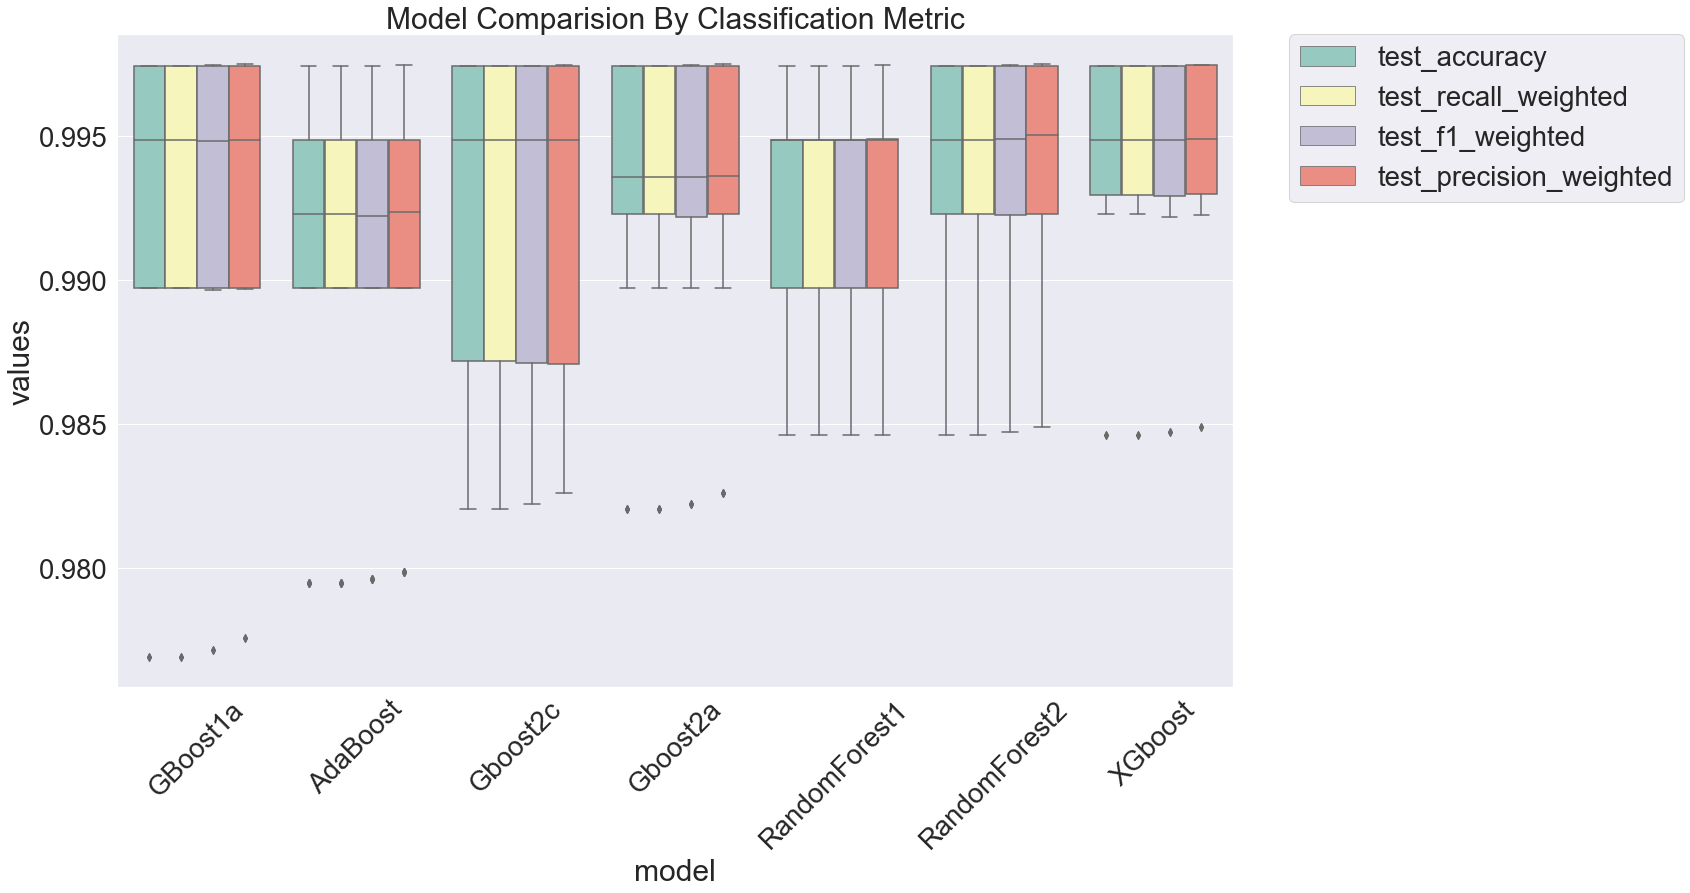

In [14]:
plot_results(scores_df)

Seeing the distribution of scores drives the point home about variance, although here I'm evaluating precision not sensitivity. No matter, seems as though the XGboost model has least variance and a comparable median score.

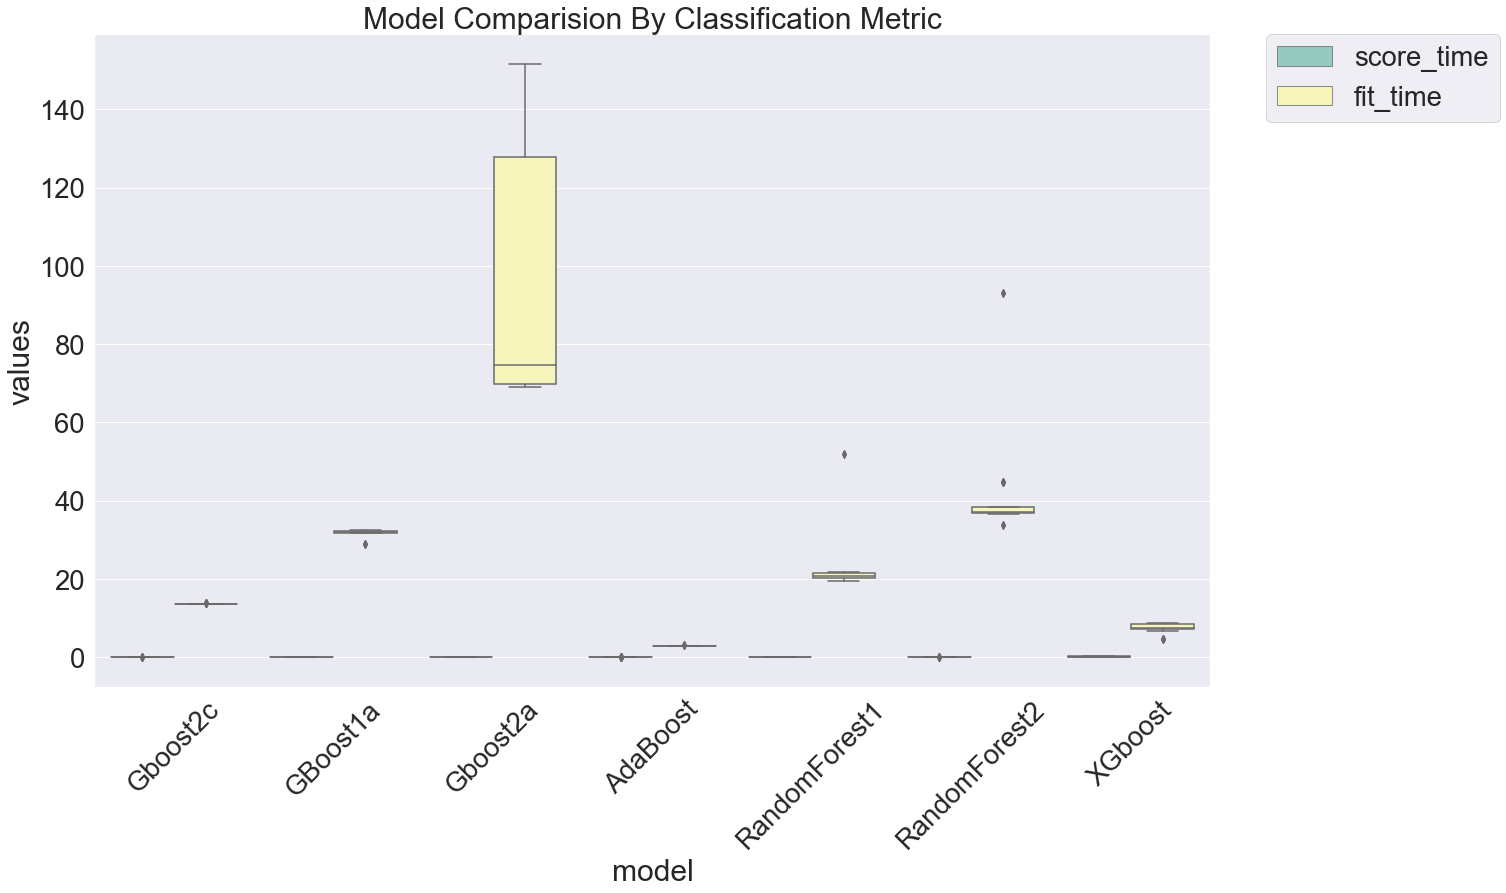

In [15]:
plot_results(times_df)

Training and scoring times are also not bad for XGboost, even if it has the worst scoring times the average is still 0.14s. 

Surprisingly, doubling the number of trees on Gboost 2a triples the training time.

In [16]:
metrics = list(set(scores_df.metrics.values))
bootstrap_df.groupby(['model'])[metrics].agg([np.std, np.mean])

test_precision_weighted           test_f1_weighted            \
                                  std      mean              std      mean   
model                                                                        
AdaBoost                     0.006373  0.990438         0.006454  0.990357   
GBoost1a                     0.005226  0.992786         0.005304  0.992734   
Gboost2a                     0.004459  0.993413         0.004558  0.993323   
Gboost2c                     0.005338  0.992036         0.005422  0.991980   
RandomForest1                0.003675  0.993340         0.003675  0.993311   
RandomForest2                0.003499  0.994330         0.003530  0.994274   
XGboost                      0.003342  0.994828         0.003391  0.994774   

              test_accuracy           test_recall_weighted            
                        std      mean                  std      mean  
model                                                                 
AdaBoost           0.006518  0.990342             0.006518  0.990342  
GBoost1a           0.005348  0.992735             0.005348  0.992735  
Gboost2a           0.004597  0.993333             0.004597  0.993333  
Gboost2c           0.005459  0.991966             0.005459  0.991966  
RandomForest1      0.003664  0.993333             0.003664  0.993333  
RandomForest2      0.003543  0.994274             0.003543  0.994274  
XGboost            0.003399  0.994786             0.003399  0.994786

In [17]:
metrics = list(set(times_df.metrics.values))
bootstrap_df.groupby(['model'])[metrics].agg([np.std, np.mean])

score_time             fit_time           
                     std      mean        std       mean
model                                                   
AdaBoost        0.007327  0.016931   0.019038   2.938622
GBoost1a        0.006374  0.011237   1.018894  31.667084
Gboost2a        0.007098  0.011556  32.140336  94.285346
Gboost2c        0.005894  0.004587   0.174418  13.561106
RandomForest1   0.006182  0.040710   7.977061  22.759847
RandomForest2   0.029365  0.053929  14.271680  41.689117
XGboost         0.008560  0.138630   1.248359   7.377860

---